# Creating RELION 3.1 Optic Groups from EPU AFIS Data

For estimating high-order aberrations and anisotropic magnification distortion in RELION 3.1 you need to organize your data into "Optics Groups" which are subsets of the data collected under similar conditions. Importantly for estimating the high-order aberrations is grouping the data by the amount of beam tilt. When data is collected in EPU using the new "Fast Acquisition" mode, EPU uses something called AFIS (Aberration Free Image Shift). Ideally this system corrects for the beam tilt induced by the applied beam-image shift to collect positions, but to be sure it useful to split each beam-image shift group into a separate Optics Group so that any remaining aberrations can be corrected.

Unfortunately EPU does not give us a good way for splitting the data into these optics groups. There's not a simple "AFIS group 1, 2, 3, ..." XML tag in the metadata. However, we can still recover this information using the beam-image shift values that is stored. The problem here is that due to the small amount of beam-image shift using on the hole-centering routine we can't just find a fixed value of beam-image shift and split the data on those values. We need a more complex solution. This notebook contains a strategy to do this.

## Note that I hate Python.

Please excuse if the code is ugly or less-than-ideal.

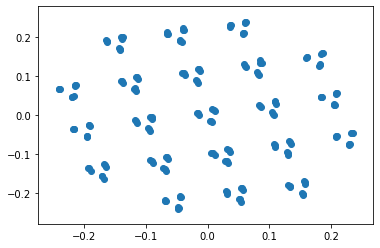

In [1]:
# Find all of the metadata files which hold the beam-image shift values.
import os, fnmatch

# We set the directory to search as just our current directory
# but you could also change top to the path to your metadata. 
top = os.getcwd()

# Create a list to store all of the metadata files
metadata_fns = []

for dirpath, dirnames, filenames in os.walk(top):
    for filename in filenames:
        if (fnmatch.fnmatch(filename, 'FoilHole_*_Data_*.xml') and
            not fnmatch.fnmatch(filename, '*_Fractions.xml')):
            metadata_fns.append(os.path.join(dirpath, filename))

# We need to parse the XML file to get the beam shift values:
import xml.etree.ElementTree

# TFS uses annoying, but proper namespaces
namespace = {'fei' : 'http://schemas.datacontract.org/2004/07/Fei.SharedObjects',
             'a' : 'http://schemas.datacontract.org/2004/07/Fei.Types'}

# Create a list to store all of the beam shifts
beam_shifts = []

for metadata_fn in metadata_fns:
    metadata = xml.etree.ElementTree.parse(metadata_fn)
    beam_shifts.append([float(x.text) for x in metadata.findall("fei:microscopeData/fei:optics/fei:BeamShift", namespace)[0]])

# Convert the list to a numpy array
import numpy

shift_array = numpy.array(beam_shifts)

# Plot a scatter plot of the beam shifts
import matplotlib.pyplot

matplotlib.pyplot.scatter(shift_array[:, 0], shift_array[:, 1])
matplotlib.pyplot.show()

# Grouping

So from the plot above you should be able to see how many holes were collected per stage movement using AFIS. The number of holes is the number of Optics Groups you want to use. You may also see clusters due to multiple shots per hole, however you should not split these further into groups as the amount of beam tilt caused by this small amount of beam-image shift is negligible and by further segmenting the data we decrease the number of measurements for each Optic Group which is important to have robust fitting of the high order aberrations against very low Signal-to-Noise Ratio data.

## **tl;dr** _Number of Optic Groups is number of "holes" in the plot above!_

In [2]:
import sklearn.cluster

# Enter the number of optic groups found above
# The data is already clustered so the algorithm should be robust.
n_clusters = 21
k_means = sklearn.cluster.KMeans(n_clusters=n_clusters)
k_means.fit(shift_array)
optics_clusters = k_means.predict(shift_array)
cluster_centers = k_means.cluster_centers_

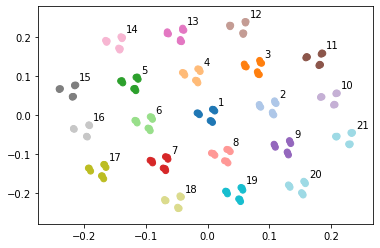

In [3]:
# To make the clusters sensible we order them by polar coordinates
radii = [x[0]**2 + x[1]**2 for x in cluster_centers]
sort_idxs = sorted(enumerate(radii), key=lambda x:x[1])

# Find the 'origin' point with smallest radius
origin = cluster_centers[sort_idxs[0][0]]

# Create some temporary variables for finding the X and Y axis of the hole "grid"
x_angle = numpy.pi
y_angle = numpy.pi
x_vec = (1, 0)
y_vec = (0, 1)

# The four points with smallest radius besides the origin contain the grid axes
for idx in range(1,5):
    point = cluster_centers[sort_idxs[idx][0]]
    angle = numpy.arctan2(point[1] - origin[1], point[0] - origin[0])
    
    # We choose the X-axis to be the point with angle closest 0
    if abs(angle) < x_angle:
        x_angle = angle
        x_vec = (point[0] - origin[0], point[1] - origin[1])
        
    # We choose the Y-axis to be the point with angle closest to 90
    if abs(angle - (numpy.pi / 2)) < abs(y_angle - (numpy.pi / 2)):
        y_angle = angle
        y_vec = (point[0] - origin[0], point[1] - origin[1])

# Create a list to store our metrics on the newly determined grid
grid_dists = []

for idx, center in enumerate(cluster_centers):
    # Center the point w.r.t. the origin
    point = (center[0] - origin[0], center[1] - origin[1])
    
    # Project the point onto x_vec, and divide it by x_vec's "unit" length
    # The projection of vec_1 onto vec_2 from linear algebra is:
    # dot(vec_1, vec_2) / |vec_2|
    #
    # and we divide again by |x_vec| which is why we have:
    # dot(point, x_vec) / |x_vec|**2
    grid_x = numpy.round((point[0] * x_vec[0] + point[1] * x_vec[1]) / (x_vec[0]**2 + x_vec[1]**2))
    grid_y = numpy.round((point[0] * y_vec[0] + point[1] * y_vec[1]) / (y_vec[0]**2 + y_vec[1]**2))
    
    # We use Manhattan distance metric so points along a unit square
    # all have same distance, which handles our corner holes.
    dist = max(abs(grid_x), abs(grid_y))
    
    # We calculate our grid index angle to sort clusters CCW
    angle = (numpy.degrees(numpy.arctan2(grid_y, grid_x)) + 360) % 360
    grid_dists.append((idx, dist, angle))

# We sort first by our distance metric and then second by angle
sort_idxs = [x[0] for x in sorted(grid_dists, key=lambda x:(x[1], x[2]))]

# Apply this sorting back to the original random clustering IDs
optics_groups = [sort_idxs.index(x) + 1 for x in optics_clusters]

# Show the cluster and sorting
figure = matplotlib.pyplot.figure()
axes = figure.add_subplot(111)
matplotlib.pyplot.scatter(shift_array[:, 0], shift_array[:, 1], c=optics_groups, cmap='tab20')

for optics_group in range(n_clusters):
    axes.annotate('{0:d}'.format(optics_group + 1), xy=cluster_centers[sort_idxs[optics_group]], textcoords='offset pixels', xytext=(10, 10))
    
matplotlib.pyplot.show()

# Wrapping Up

So now that we have our Optics Groups all assigned the only thing left to do is to write out the STAR file.

This is just the bare minimum that you would get using the Import in RELION. You may have to modify this file a bit to make sure that the paths to the micrographs are correct.

_Here in the notebook I am using print statements to show the result, in the script it would write to file._

In [5]:
# We need to set some values here for the STAR file
# Pixel size in Angstroms
apix = 1.00
mtf_fn = 'MTF.star'
# Voltage in keV
voltage = 300
# Spherical aberration in mm
cs = 2.7
# Amplitude Contrast (0-1)
q0 = 0.1
# movie extension
ftype='tif'

# We sort the micrographs by name first and then by Optics Group
entries = sorted(zip(metadata_fns, optics_groups), key=lambda x:(x[0], x[1]))

print('\n# version 30001\n')
print('data_optics\n\nloop_')
print('_rlnOpticsGroupName #1')
print('_rlnOpticsGroup #2')
print('_rlnMtfFileName #3')
print('_rlnMicrographOriginalPixelSize #4')
print('_rlnVoltage #5')
print('_rlnSphericalAberration #6')
print('_rlnAmplitudeContrast #7')
    
for optics_group in range(1, n_clusters + 1):
    print('opticsGroup{0:d}\t{1:d}\t{2}\t{3:15.6f}\t{4:15.6f}\t{5:15.6f}\t{6:15.6f}'.format(
            optics_group, optics_group, mtf_fn, apix, voltage, cs, q0))

print(' \n\n# version 30001\n')
print('data_movies\n\nloop_')
print('_rlnMicrographMovieName #1')
print('_rlnOpticsGroup #2')
    
for metadata_fn, optics_group in entries:
    base = os.path.basename(metadata_fn)
    root, ext = os.path.splitext(base)
    print('{0}.{1}\t{2:d}'.format(root, ftype, optics_group))



# version 30001

data_optics

loop_
_rlnOpticsGroupName #1
_rlnOpticsGroup #2
_rlnMtfFileName #3
_rlnMicrographOriginalPixelSize #4
_rlnVoltage #5
_rlnSphericalAberration #6
_rlnAmplitudeContrast #7
opticsGroup1	1	MTF.star	       1.000000	     300.000000	       2.700000	       0.100000
opticsGroup2	2	MTF.star	       1.000000	     300.000000	       2.700000	       0.100000
opticsGroup3	3	MTF.star	       1.000000	     300.000000	       2.700000	       0.100000
opticsGroup4	4	MTF.star	       1.000000	     300.000000	       2.700000	       0.100000
opticsGroup5	5	MTF.star	       1.000000	     300.000000	       2.700000	       0.100000
opticsGroup6	6	MTF.star	       1.000000	     300.000000	       2.700000	       0.100000
opticsGroup7	7	MTF.star	       1.000000	     300.000000	       2.700000	       0.100000
opticsGroup8	8	MTF.star	       1.000000	     300.000000	       2.700000	       0.100000
opticsGroup9	9	MTF.star	       1.000000	     300.000000	       2.700000	       0.100000
opticsGr